# Python Learn by Doing: Climate Change Indicators, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Date:** May 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter

**Link:** this notebook available to download at [climate_change_indicators_option1.ipynb](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators_option1.ipynb)

---
**Assignment:**

Calculate the monthly mean daily temperature range (DTR) at Starkville, determine whether there is a statistically significant trend, and create a figure showing the DTR timeseries, linear trend, and p value. Compare your results to climdex.org, looking at the trend in DTR over CONUS for similar data years (1977-2021) and also for data years 1922-2021 from the Berkeley Earth Surface Temperature dataset

&emsp;Hints:
- Use daily tmax and tmin data
- Apply the relevant steps from the data cleaning section (drop leap days)
- Calculate the daily temperature range as tmax-tmin
- For each month, find the mean daily temperature range
- Determine if there is a statistically significant trend in DTR at the 90% confidence level
- Plot the DTR timeseries with its linear trend line. Your plot should have x axis tick labels as years, a y axis label that describes the units, and a title that includes the p value.
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of DTR trend over CONUS using data years 1977-2021 from the BEST dataset
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of DTR trend over CONUS using data years 1922-2021 from the BEST dataset

# Import packages and define workspace

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

In [ ]:
# path to your working directory (where this notebook is on your computer)
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/' 

# path to the data files
data_dir = work_dir+r'data/AgERA5_daily/'

# Data Cleaning

Normally, we would run through the data cleaning suggested by ETCCDI here. However, we've already done the data cleaning steps in climate_change_indicators_AgERA5.ipynb and found that, using the Starkville data, the leap days step was the only step that changed our data arrays. We'll repeat only that step here.

In [ ]:
tn = xr.open_dataarray(data_dir+'tmin_AgERA5_Starkville_Daily_1979-2023.nc')
tn = tn.squeeze()

tx = xr.open_dataarray(data_dir+'tmax_AgERA5_Starkville_Daily_1979-2023.nc')
tx = tx.squeeze()

tn

In [ ]:
#### leap days (i.e Feb 29th)
# we'll drop all leap days from the data arrays

# first let's double check that the time dimension is the same for all of our data arrays
assert list(tn.time.data)==list(tx.time.data), 'tn.time and tx.time are not equal'

# create a boolean array of dim 'time' where leapdays are True and all other days are False
isleapday=xr.where((tn.time.dt.day==29) & (tn.time.dt.month==2),True,False)

# drop leapdays
tx=tx.where(~isleapday,drop=True)
tn=tn.where(~isleapday,drop=True)

len(tx), len(tn)

#  Climate change indicator: monthly mean daily temperature range (DTR)

In [ ]:
dtr_daily=tx-tn
dtr_daily

In [ ]:
# create a label for every month in the timeseries
month_groups=pd.MultiIndex.from_arrays([tn.time['time.year'].data,tn.time['time.month'].data])

# add month_groups as a new coordinate
dtr_daily.coords['month_groups']=('time',month_groups) 

dtr_daily

In [ ]:
# calculate mean daily temperature range for each month
DTR=dtr_daily.groupby('month_groups').mean()

# change the month_groups dim name and coordinate labels to datetimes
time_months=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='MS') # create datetimes
DTR=DTR.rename({'month_groups':'time'})  # renaming a coordinate and dimension
DTR=DTR.drop_vars(['time_level_0','time_level_1']) # deleting leftovers from MultiIndex that we don't need
DTR.coords['time']=('time',time_months)  # assign datetimes as the coordinate values/labels 

DTR

In [ ]:
# plot
fig=plt.figure(figsize=(15,2))
DTR.plot()
plt.title('monthly mean daily temperature range (DTR)')
plt.ylabel('degrees C')
plt.show()

# Trend analysis

In [ ]:
# linear regression and p value

# an integer index as a new coordinate
DTR.coords['index']=('time',range(len(DTR.time)))

# linear regression
reg_info=ss.linregress(DTR.index,DTR)

# convert trend units
trend=reg_info.slope*12*100 # C/month --> C/century

# create regression line for plotting
regline=reg_info.slope*DTR.index +reg_info.intercept

reg_info

In [ ]:
# plot the linear regression over the timeseries TNx
fig=plt.figure(figsize=(15,2))

DTR.plot()
regline.plot(linestyle='--')

plt.axhline(y=DTR.mean(),color='grey',linestyle='dashed',linewidth=0.5)
plt.tick_params(labelright=True, right=True)
plt.ylabel('degrees C')
plt.title(f'monthly mean daily temperature range (DTR) with trend {trend:.2f} C/century (p={reg_info.pvalue:.3f})')

# plt.savefig('figs/cci_option1_figure.png')
plt.show()

# Conclusions

With a p value of 0.724, there is no statistically significant trend in Starkville DTR


We find a similar result at Starkville from climdex.org, using BEST data over the years 1977-2021 to calculate DTR trend. However, there do appear to be significant trends of increasing DTR across much of the southwest US and Pacific northwest US. 


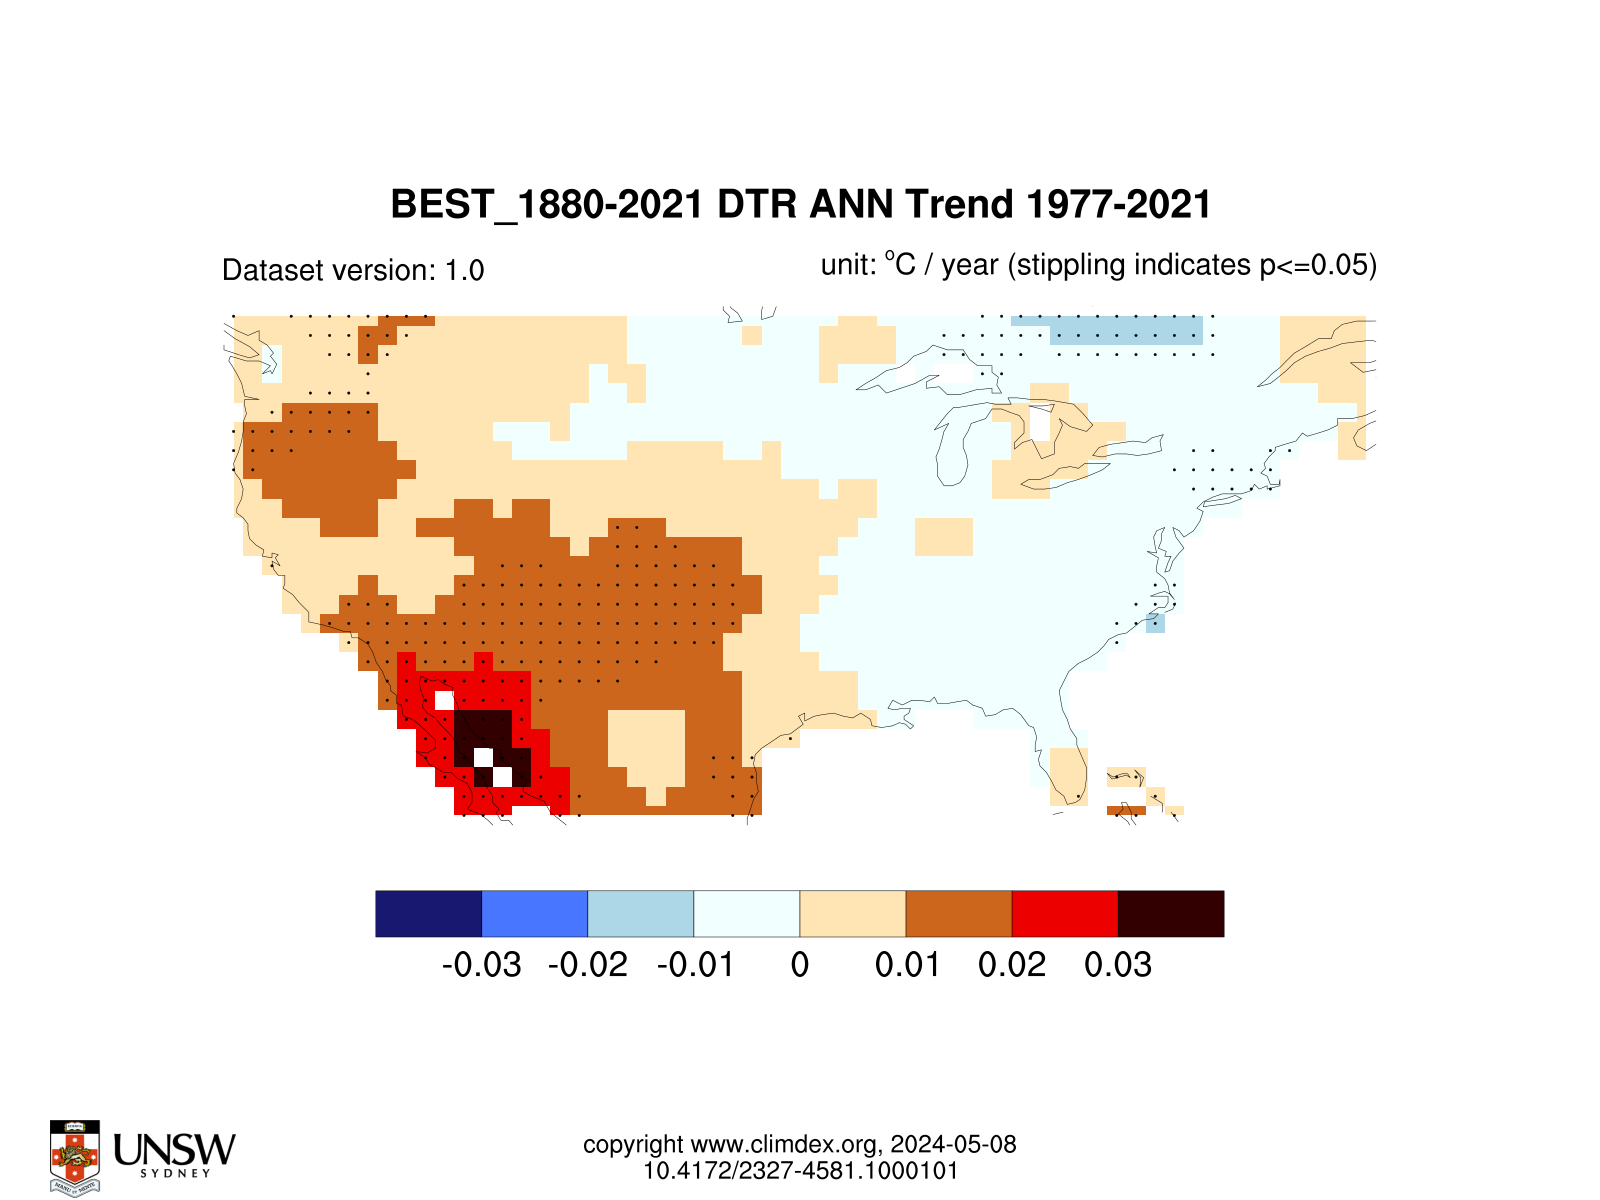

<br>
<br>

If the trends above are robust long term trends, then we should see a similar result using more data years. If we use 100 total data years, do we see the same pattern of trends and similar areas of statistical significance over CONUS? 



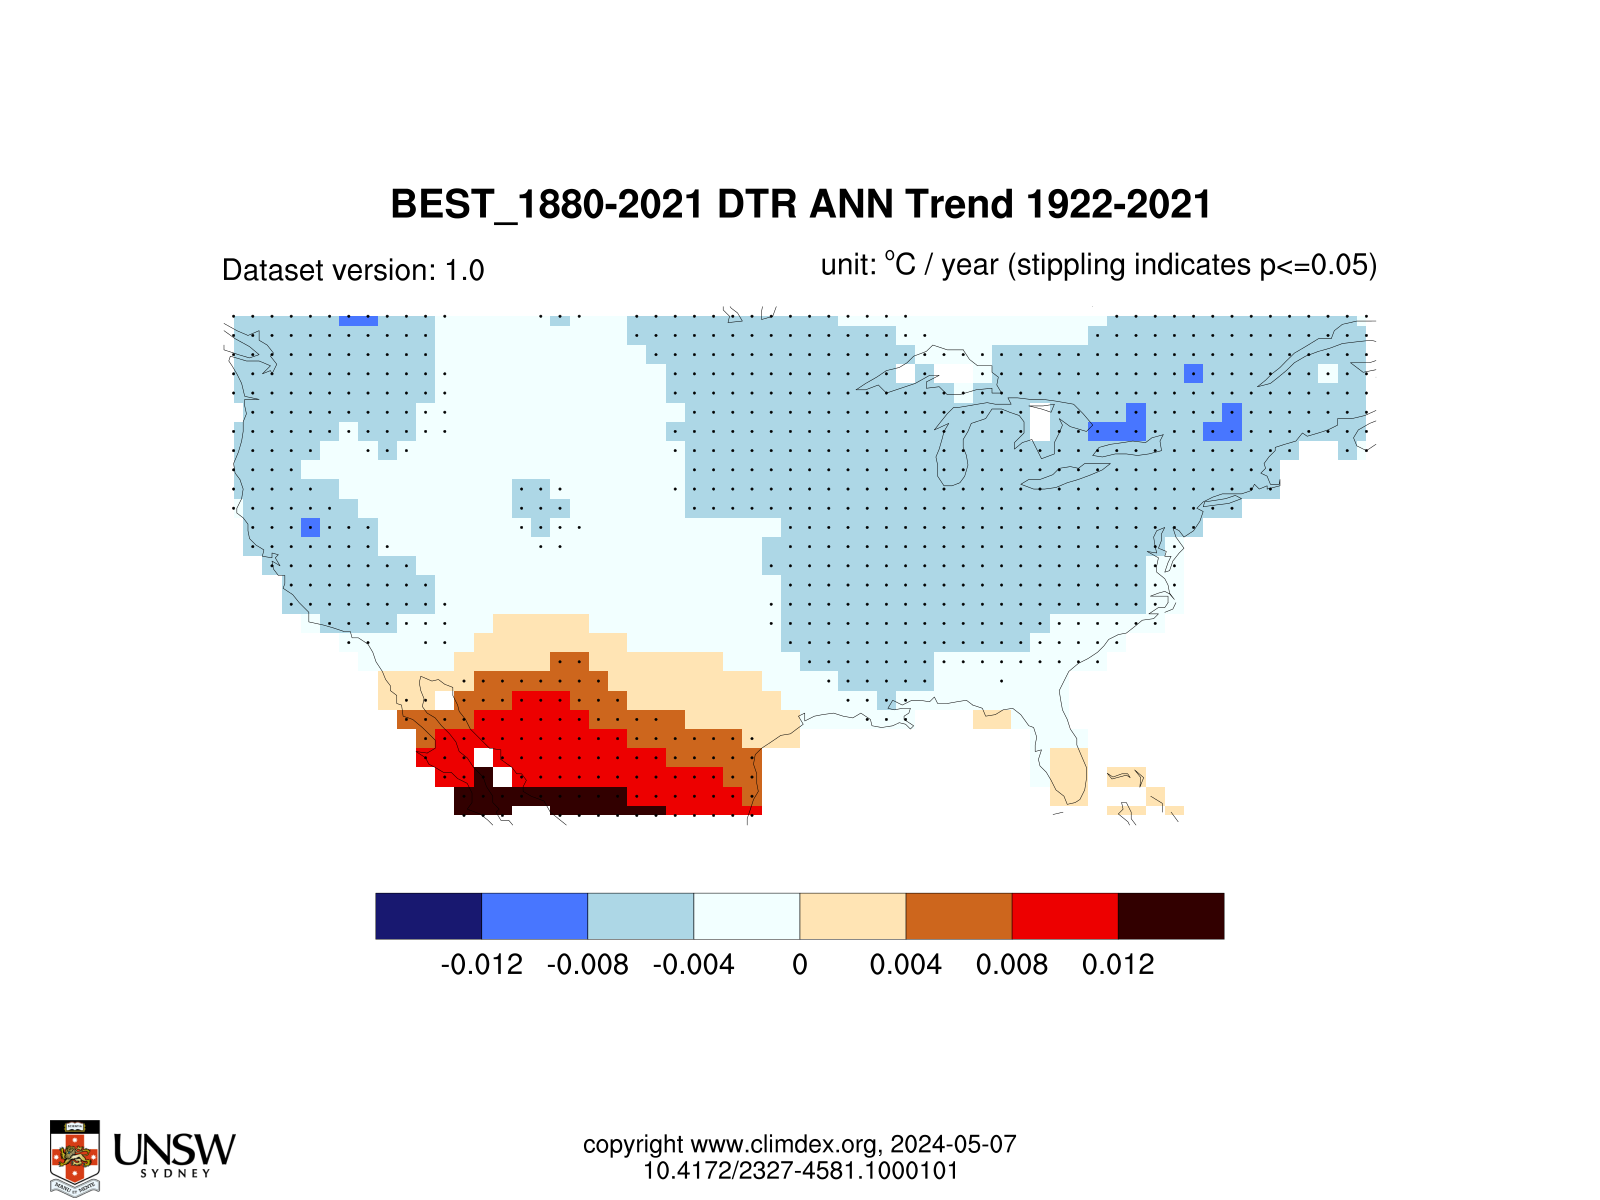

The answer is no, not really (with the exception of the baja peninsula)!

In climate science, 45 years of data is not considered to be a lot of data, especially for trend analysis. If there are more years of reliable data available, it's usually better to use more years in your trend analysis. We can consider the result using 100 years of data more robust and representative of long term change than the result using only 45 years of data.

One last point to consider is the following... the BEST gridded temperature dataset provides data values all the way back to 1880 globally. We could have looked at the trend calculated on all 142 years of available data. BUT, you should take into account that data collected that long ago is MUCH more sparse and potentially less reliable than data collected in more recent years. So while 1880-1921 data years do exist in the BEST dataset, it's likely that there was much more interpolation of the data observations when gridding them.  